# Meteorological data timeseries analysis with python (Advanced)
Continue analyse "big data" meteorological timeseries with dask and folium.

### Initialization

In [1]:
import pandas as pd
import dask.dataframe as dd # pandas df BIG DATA fast loading trick
import numpy as np
import scipy as sp
import scipy.ndimage
from scipy import stats
from scipy.fftpack import fft, fftfreq
from scipy.interpolate import griddata,RegularGridInterpolator
import ast
import re
import sys, os, os.path
import time
from datetime import datetime

In [2]:
import plotly.offline as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.io as pio
py.init_notebook_mode(connected=True)

In [3]:
import folium
from folium import plugins
import geojsoncontour
import branca
import pylab
import matplotlib.pyplot as plt
import matplotlib

In [4]:
import selenium.webdriver # if you want to convert folium map to jpeg image

In [5]:
# don't forget to unzip wr16296.zip in data/orig/
dirname = "data/orig/wr16296/"
statlist = "statlist16296.txt"
result = "data/result/"
# os.mkdir(result)

### Data loading

In [6]:
# OpenCageGeocode module for get stations locations
# uncomment to write locations to the file

# from opencage.geocoder import OpenCageGeocode

# key = '0bd59b6de06241fe9ccd47e69a37d781'
# geocoder = OpenCageGeocode(key)

# f = open(dirname + statlist)
# geocodeStations = dict()
# for lines in f:
#     rowData = re.split("[0-9]+",lines.replace("\n",""))
#     if(len(rowData) != 0 and lines.split(" ")[0] != "\n"):
#         stationAddress = rowData[1].strip()
#         results = geocoder.geocode(stationAddress)
#         if(len(results[0]) != 0):
#             geocodeStations[int(lines.split(" ")[0])] = [stationAddress, results[0]['geometry']['lng'], results[0]['geometry']['lat']]
#         else:
#             geocodeStations[int(lines.split(" ")[0])] = [stationAddress, 0., 0.]

In [7]:
# Read ready stations locations file (Addr, Lat, Long format)

# locAddr = dict()
# locLon = dict()
# locLat = dict()

# fi = open(dirname + statlist)
# stationIdxes = []
# for line in fi:
#     stationIdx = line.split(" ")[0]
#     stationIdx = stationIdx.strip().replace("\n","").replace("'","")
#     if(stationIdx != ""):
#         stationIdxes.append(int(stationIdx))

# fc = open("coords","r")
# for idx, line in zip(stationIdxes,fc):
#     location = line.split("[")[1].strip().replace("]","").replace("'","").split(",")
#     l = len(location)
# #     geocodeStations[idx] = [" ".join(location[0:l-2]).strip(), location[l-2].strip(), location[l-1].strip()]
#     locAddr[idx] = " ".join(location[0:l-2]).strip()
#     locLon[idx] = float(location[l-2])
#     locLat[idx] = float(location[l-1])
    
# print(locAddr)

In [8]:
# Modify stations info file to get decimal float coordinates degrees

# import re

# df_stations = dd.read_csv("stations.csv", sep=";")
# df_stations = df_stations.set_index("Index")

# df_stations['Latitude'] = df_stations['Latitude'].compute().apply(lambda x: str(x).replace("o","").replace("°","").replace("","").replace("","").replace("’","").replace("¢","").replace("о","").replace(" ",""))
# df_stations['Longitude'] = df_stations['Longitude'].compute().apply(lambda x: str(x).replace("o","").replace("°","").replace("","").replace("","").replace("’","").replace("¢","").replace("о","").replace(" ",""))
# df_stations["Latitude"] = df_stations["Latitude"].compute().apply(lambda x: str(float(str(x)[0:len(str(x))-2]) + float(str(x)[len(str(x))-2:len(str(x))].replace("’",""))/60)).astype(float)
# df_stations["Longitude"] = df_stations["Longitude"].compute().apply(lambda x: str(float(str(x)[0:len(str(x))-2]) + float(str(x)[len(str(x))-2:len(str(x))].replace("’",""))/60)).astype(float)
# df_stations = df_stations.compute()
# df_stations["Latitude"][33910] = 46.1
# df_stations.to_csv("stations_mod.csv", sep=";")

In [9]:
df_stations = dd.read_csv("data/stations_mod.csv", sep=";")

In [10]:
# Simplify parameters getting
def getT():
    return ["TemperatureMin", 
            "Temperature", 
            "TemperatureMax"]
def getP():
    return ["Precipitation"]

# # Declare columns headers

# headers = ["StationIdx",
#            "Year",
#            "Month",
#            "Day",
#            "Quality",
#            "TemperatureMin", 
#            "Temperature", 
#            "TemperatureMax", 
#            "Precipitation"]

# # Load data f to pandas df
# df = dd.read_csv(datafile, sep=";", header=None, names=headers, na_values="     ")

In [11]:
# df = df.dropna()
# df["Address"] = df["StationIdx"].map(locAddr)
# df["Longitude"] = df["StationIdx"].map(locLon)
# df["Latitude"] = df["StationIdx"].map(locLat)
# df.to_csv('/home/egor/work/master/tree/jupyter/meteo/new/*.csv')

In [12]:
df = dd.read_csv('data/prep/*.csv')

In [13]:
# df["Datetime"] = df["Datetime"].astype("datetime64[ns]")
# df = df.set_index("Datetime")

In [14]:
# Get extremal parameters values for all time
t_abs_min = df["TemperatureMin"].min().compute()
t_abs_max = df["TemperatureMax"].max().compute()
p_abs_max = df["Precipitation"].max().compute()
print(t_abs_min, t_abs_max, p_abs_max)

-65.5 49.1 258.4


In [15]:
# Add Latitude, Longitude and information to df
df_ext = dd.merge(df[["Datetime","StationIdx"]+getT()+getP()],df_stations[["Latitude", "Longitude","Index"]],left_on="StationIdx", right_on = "Index", how = 'left')
df_ext = df_ext.drop(["Index"],axis=1)
df_ext.head()

,Datetime,StationIdx,TemperatureMin,Temperature,TemperatureMax,Precipitation,Latitude,Longitude
0,1919-01-01,33910,2.7,9.2,12.5,0.0,46.100000,34.816667
1,1919-01-01,22583,-20.5,-15.5,-11.0,0.0,64.750000,47.650000
2,1919-01-01,22550,-22.8,-17.0,-11.8,0.1,64.500000,40.733333
3,1919-01-01,38457,-1.2,3.7,9.8,0.0,41.266667,69.266667
4,1919-01-01,27995,-15.7,-7.5,-4.4,4.2,52.983333,49.433333


In [16]:
# Then set index
df_stations = df_stations.set_index("Index")
df_stations = df_stations.compute()

In [17]:
# Check extended dataframe
df_ext.head()

,Datetime,StationIdx,TemperatureMin,Temperature,TemperatureMax,Precipitation,Latitude,Longitude
0,1919-01-01,33910,2.7,9.2,12.5,0.0,46.100000,34.816667
1,1919-01-01,22583,-20.5,-15.5,-11.0,0.0,64.750000,47.650000
2,1919-01-01,22550,-22.8,-17.0,-11.8,0.1,64.500000,40.733333
3,1919-01-01,38457,-1.2,3.7,9.8,0.0,41.266667,69.266667
4,1919-01-01,27995,-15.7,-7.5,-4.4,4.2,52.983333,49.433333


### Temperature map drawing

In [18]:
# Generate colormap
levels = np.arange(-70,55,5)
cmap = pylab.cm.get_cmap('Spectral_r', len(levels))    # PiYG
colors=[]
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors.append(matplotlib.colors.rgb2hex(rgb))
cm = branca.colormap.LinearColormap(colors, vmin=-70, vmax=50).to_step(len(levels)-1)

In [19]:
# Get meteostations location map
meteostationsMap = folium.Map(location=[60,102], zoom_start=3, tiles="cartodbpositron")
for lat, long, name in zip(df_stations["Latitude"].tolist(),df_stations["Longitude"].tolist(),df_stations["Name"].tolist()):
#     meteostationsMap.add_child(folium.CircleMarker(location=[lat,long], popup=name, radius=1,fill=True, color="#4169E1", fill_color="#4169E1"))
    meteostationsMap.add_child(folium.Marker(location=[lat,long], popup=name))
meteostationsMap.save(result + 'meteostations.html')

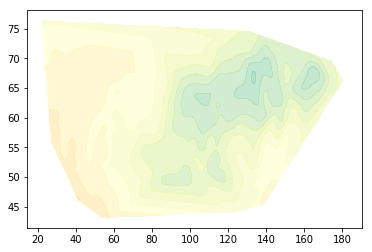

In [20]:
# Draw Temperature dynamics on whole map
Dates = ["2018-01-01"]
grouped = df_ext.compute().groupby("Datetime")
for name, group in grouped:
    
    if name not in Dates:
        continue
        
    # The original data
    x_orig = np.asarray(group["Longitude"].tolist())
    y_orig = np.asarray(group["Latitude"].tolist())
    z_orig = np.asarray(group["Temperature"].tolist())

    # Make a grid
    x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 500)
    y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 500)
    x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)

    # Grid the values
    z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')
    
    # Uncomment if you want to get averaged temperature value
#     itp = RegularGridInterpolator( (x_arr, y_arr), z_mesh, method='linear') 
#     res = itp((38.9,47.2))
#     print(res)

    # Gaussian filter the grid to make it smoother
    sigma = [5, 5]
    z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')

    contourf = plt.contourf(x_mesh, y_mesh, z_mesh, alpha=0.5, levels=range(-70,50,5), colors=colors, linestyles='None')

    # Convert matplotlib contourf to geojson
    geojson = geojsoncontour.contourf_to_geojson(
        contourf=contourf,
        min_angle_deg=3.0,
        ndigits=5,
        stroke_width=1,
        fill_opacity=0.5)

    # Set up the folium plot
    geomap = folium.Map(location=[60,102], zoom_start=3, tiles="cartodbpositron")

    # Plot the contour plot on folium
    folium.GeoJson(
        geojson,
        style_function=lambda x: {
            'color':     x['properties']['stroke'],
            'weight':    x['properties']['stroke-width'],
            'fillColor': x['properties']['fill'],
            'opacity':   0.5,
        }).add_to(geomap)

    # Add the colormap to the folium map
    cm.caption = 'Temperature'
    geomap.add_child(cm)

    # Fullscreen mode
    plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap)

    # Plot the data
    geomap.save(result + 'temperature_map_{}.html'.format(name))
    
    # Uncomment lines below to take a map image

#     os.environ['PATH'] = os.environ['PATH']+":~/Downloads/chromedriver_linux64"

#     driver = selenium.webdriver.Chrome()
#     driver.set_window_size(1024, 768)  # choose a resolution
#     driver.get('file://{}/map.html'.format(os.getcwd()))
#     time.sleep(3)
#     # You may need to add time.sleep(seconds) here
#     driver.save_screenshot('screenshot.png')
#     driver.quit()

### Gydro Termal Coefficient of Selyaninov and FFT analysis

In [21]:
def GydroTermalCoef(x):
    GTC = 1.0
    
    x = pd.DataFrame(x)
    y = x["Precipitation"].tolist()
    x = x["Temperature"].tolist()
    
    periods = []
    i = 0
    n = len(x) - 1
    while i < n:
        
        period = []
        while i < n:
            if x[i] >= 10:
                period.append(x[i])
                i += 1
            else:
                break
        if len(period) > 0:
            periods.append(period)
        
        period = []
        while i < n:
            if x[i] < 10:
                period.append(x[i])
                i += 1
            else:
                break
        if len(period) > 0:
            periods.append(period)
        
    # we have periods, next we can find the next one with positive sum > negative sum
    sums = []
    for i in range(0,len(periods)):
        sums.append(sum(periods[i]))
    
    # search spring day 0 temperature transition
    springDay10 = 0
    i = 0
    while i < len(sums):
        if(sums[i] < 10):
            i += 1
        else:
            finded = True
            for j in range(i + 1, len(sums)):
                if sums[j] < 10 and abs(sums[j]) > sums[i]:
                    finded = False
            if finded:
                for j in range(0, i):
                    springDay10 += len(periods[j])
                break
            else:
                i += 1
                
    # the same stuff for autumn
    autumnDay10 = 0
    while i < len(sums):
        if(sums[i] > 10):
            i += 1
        else:
            finded = True
            for j in range(i + 1, len(sums)):
                if sums[j] > 10 and sums[j] > abs(sums[i]):
                    finded = False
            if finded:
                for j in range(0, i):
                    autumnDay10 += len(periods[j])
                break
            else:
                i += 1   
                
    St = sum(x[springDay10:autumnDay10])
    if St > 0 and springDay10 != 0 and autumnDay10 != 0:
        GTC = 10 * sum(y[springDay10:autumnDay10])/St

    return float(GTC)

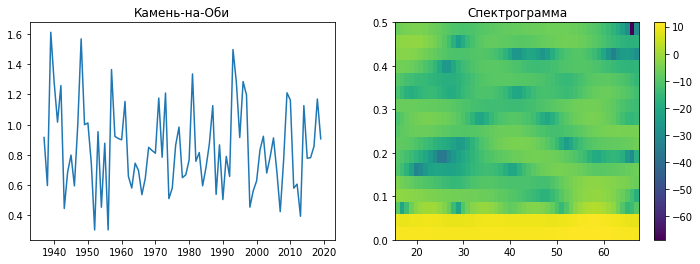

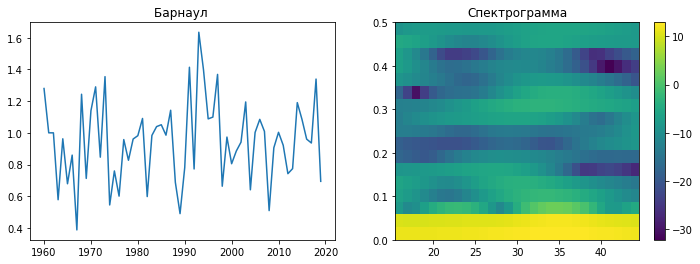

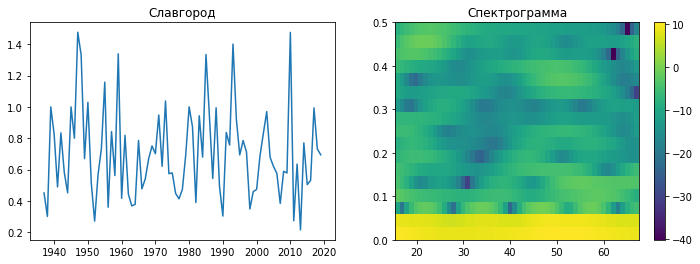

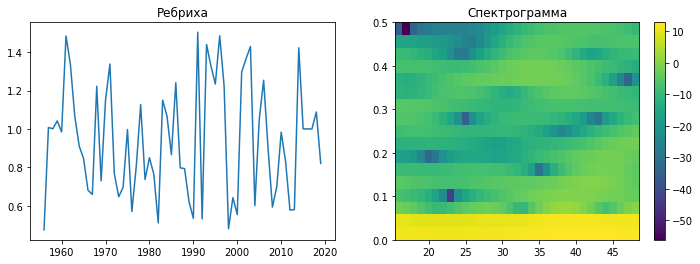

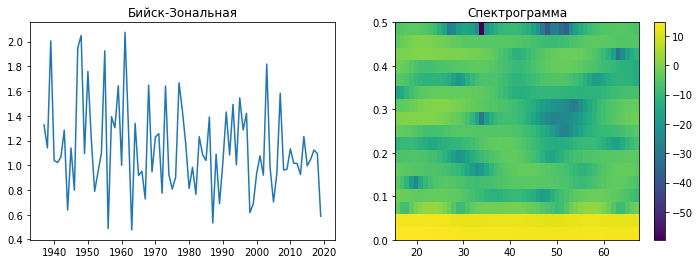

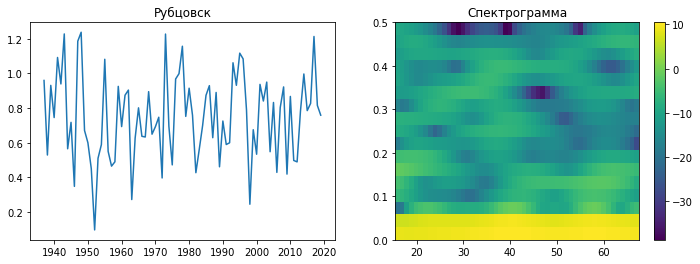

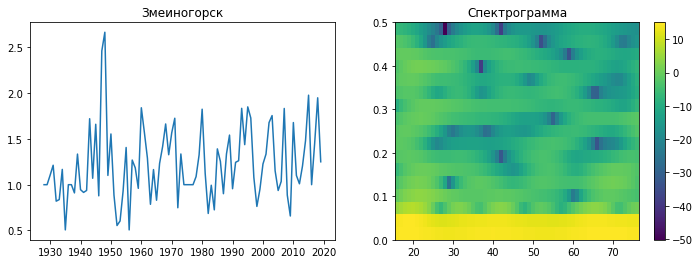

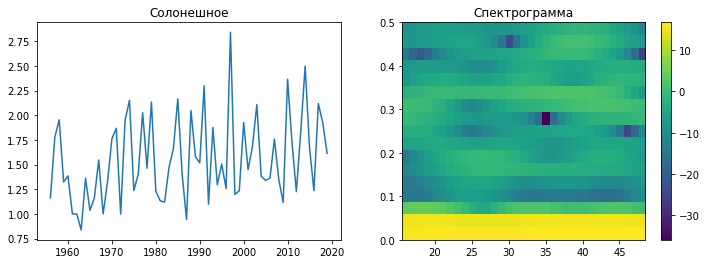

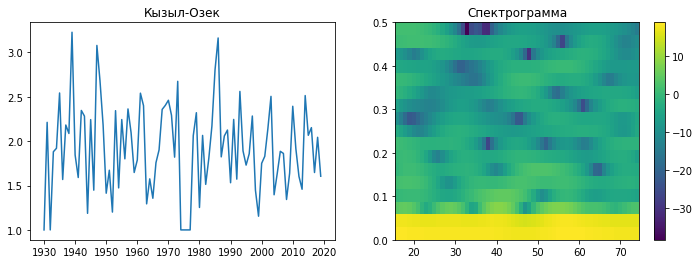

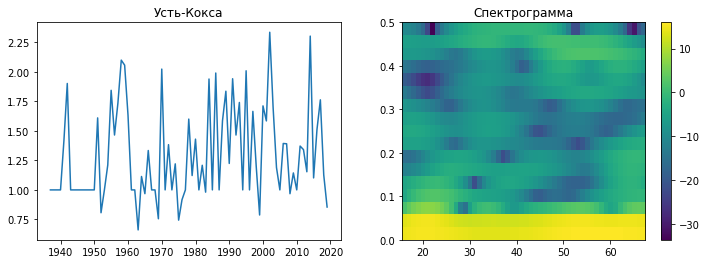

In [22]:
# Draw Temperature, Percipitation, GTC dynamics for each station of Altai
grouped = df_ext.compute().groupby("StationIdx")
AltaiMeteostations = [29915, 29822,29838,29923,36034,36038,36045,36055,29939,36229]#,36442,36259]
for name, group in grouped:

    if name not in AltaiMeteostations:
        continue

    group["Datetime"] = group["Datetime"].astype("datetime64[ns]")
    group = group.set_index("Datetime")
    
    stationName = str(df_stations["Name"][name]).replace("Им.","")
    
# # Work with temperature
#     data = group["Temperature"].resample("Y").mean().rolling(10, min_periods=10).mean().dropna()
    
#     # Estimate trend
#     temperature = data.tolist()
#     idx = np.arange(0,len(temperature))
#     slope, intercept, r_value, p_value, std_err = stats.linregress(idx,temperature)
#     line = slope * idx + intercept
    
#     # Info message
#     message = "Темп прироста " + str(round(slope,2)) + "°C/год"
    
#     # Draw graphic
#     layout = go.Layout(
#         title="Динамика среднегодовой температуры,<br>" + stationName + ".<br>" + message,
#         xaxis=dict(title = "Год", type='date'),
#         yaxis=dict(title = "Температура, °C"),
#     )
#     trace1 = go.Scatter(x = data.index, y=data, name="Данные")
#     trace2 = go.Scatter(x = data.index, y=line, name='Аппроксимация')
#     fig = go.Figure(data=[trace1,trace2], layout=layout)
#     py.offline.plot(fig, filename=str(name)+'_temperature.html')
    
# # Work with precipitation
#     data = group["Precipitation"].resample("Y").sum().rolling(10, min_periods=10).mean().dropna()
    
#     # Estimate trend
#     precipitation = data.tolist()
#     idx = np.arange(0,len(precipitation))
#     slope, intercept, r_value, p_value, std_err = stats.linregress(idx,precipitation)
#     line = slope * idx + intercept
    
#     # Info message
#     message = "Темп прироста " + str(round(slope,2)) + " мм/год"
    
#     # Draw graphic
#     layout = go.Layout(
#         title="Динамика годовой суммы осадков,<br>" + stationName + ".<br>" + message,
#         xaxis=dict(title = "Год", type='date'),
#         yaxis=dict(title = "Сумма осадков, мм"),
#     )
#     trace1 = go.Scatter(x = data.index, y=data, name="Данные")
#     trace2 = go.Scatter(x = data.index, y=line, name='Аппроксимация')
#     fig = go.Figure(data=[trace1,trace2], layout=layout)
#     py.offline.plot(fig, filename=str(name)+'_precipitation.html')
    
    data = group[["Temperature","Precipitation"]].resample("Y").apply(GydroTermalCoef)
    x = data.dropna().tolist();
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(data.dropna().index.tolist(),x); 
    ax1.set_title(stationName)
    pxx,  freq, t, cax = ax2.specgram(x,NFFT=32, Fs = 1, Fc=0, noverlap=31, window=np.blackman(32));
    fig.colorbar(cax)
    ax2.set_title("Спектрограмма")
    
#     # Draw graphic
#     layout = go.Layout(
#         title="Динамика изменений гидротермического коэффициента,<br>" + stationName + ".",
#         xaxis=dict(title = "Год", type='date'),
#         yaxis=dict(title = "ГТК"),
#     )
#     trace = go.Scatter(x = data.index, y=data, name="Данные")
#     fig = go.Figure(data=[trace], layout=layout)
#     py.offline.plot(fig, filename=str(name)+'_gtc.html')
    plt.savefig(result + "/gtc/" + str(name)+'.png')